# Smart Search: Canadian University Clustering

## Introduction

Thousands of foreign nationals troop into Canada every year in search of University education. This is due largely to Canada's 'flexible' immigration policy, quality education, comparative lower tuition and consistent high ranking for overall quality of life. Prospective students are presented with a deluge of options from which to make a choice - no mean fit by any standard, as Canada has a plethora of reputable Univesities across its provinces and territories. It would certainly be helpful if these young and enthusiastic ones were gifted a tool or platform to help, at least, point them in the right direction in their search. 

This notebook offers a lifeline. Canadian Universites are organized into clusters predicated upon pre-selected attributes(or features). Each cluster comprises Universities having a unique combination of attributes - which we call 'cluster description'. Prospective students can then identify the cluster into which to focus their search based on the accompanying cluster description. Thus the search experience is refined, effective and less time consuming.

The notebook presentation is made in three parts:

[PART ONE: Data Gathering](#PART-ONE:-Data-Gathering)

The list of Canadian Universities and respective rankings, Provincial rent rates and geographical coordinates are obtained. The first two items are gleaned from webpages, employing the BeatifulSoup library. The goepy library is used to produce the longitudinal and latitudinal coordinates of the Universities.

[PART TWO: The Recreational Index (RI)](#PART-TWO:-The-Recreational-Index-(RI))

The recreational index is a derivation of the available recreation 'fun' spots within 500m of the Institution. The Foursqaure API is used to obtain these recreation venues (employing the coordinates obtained earlier) located in close proximity of the Univerisities, from which the RI is subsequently derived.

[PART THREE: University Clusters](#PART-THREE:-University-Clusters)

The k-means machine learning algorithm is implemented to produce unique University clusters. Cluster descriptions are ascribed to each cluster upon examination of k-means algorithm output. Charts are also presented to showcase cluster composition. 

# PART ONE: Data Gathering

### Import Libraries

In [800]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# import k-means for clustering 
from sklearn.cluster import KMeans

#Import StandardScaler for Normalization
from sklearn.preprocessing import StandardScaler

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# render great maps
import folium

pd.set_option('display.max_rows', None)



### List of Canadian Universities and their situated Province

The list of Canadian Universities which will serve as the backbone of our data, is obtained from the Wikipedia webpage. The Beautiful Soup library is used for the task.

In [781]:
url = 'https://en.wikipedia.org/wiki/List_of_universities_in_Canada#mw-head'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')


In [ ]:
# Extract 'University list' data from webpage into Dataframe

data = pd.DataFrame()
row = []
table = soup.find_all('table', class_='wikitable sortable')[0:10]
Province = ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 
            'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan']

for table, Province in zip(table, Province):
    for tr in table.find_all('tr'):
        prov = [Province]
        td = tr.find_all('td')[0:2]
        row = prov + [td.text for td in td]
        data = data.append([row])

data.columns = ['Province', 'University', 'City']        
data = data[2:].reset_index(drop=True)

In [ ]:
# Clean up resulting Dataframe

# Define function to clean up Dataframe
def clean_up(df): 
    columns = df.columns.to_list()

# Remove the undesired '\n' from Dataframe elements
    for column in columns:  
        df[column] = df[column].apply(lambda x: x.rstrip('\n') if isinstance(x, str) else x)

clean_up(data) # call 'clean_up' function

data['University'] = data['University'].apply(lambda x: x.split('[')[0] if isinstance(x, str) else x)
    
data

In [777]:
# Remove null rows
pd.set_option('display.max_colwidth', -1)

data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data

,Province,University,City,Rental Rates
0,Alberta,Alberta University of the Arts,Calgary,1105.0
1,Alberta,Athabasca University,"Athabasca, Calgary, Edmonton",1105.0
2,Alberta,MacEwan University,Edmonton,1105.0
3,Alberta,Mount Royal University,Calgary,1105.0
4,Alberta,University of Alberta,"Edmonton, Camrose, Calgary",1105.0
5,Alberta,University of Calgary,"Calgary, Edmonton",1105.0
6,Alberta,University of Lethbridge,"Lethbridge, Edmonton, Calgary",1105.0
7,British Columbia,Capilano University,North Vancouver,1800.0
8,British Columbia,Emily Carr University of Art and Design,Vancouver,1800.0
9,British Columbia,Kwantlen Polytechnic University,"Richmond, Surrey, Langley, Cloverdale",1800.0


### Provincial Rent Rates 

Median rental rates for each province has been obtained from Rentals.ca (https://rentals.ca/national-rent-report#provincial-rental-rates). It should be noted that these rates are representative of an entire Province. Consequently, actual rates across cities within a Province may show some discrepancy.

In [778]:
# Create preliminary DataFrame with rental rates
Province_list = list(data.groupby('Province', as_index=False).count()['Province'])
Province_list
Rental_rates = [1105, 1800, 1195, 855, 855, 1495, 2080, 1495, 1495, 995]
Province_rates = pd.DataFrame({'Rentals':Rental_rates}, index=Province_list)

Province_rates

,Rentals
Alberta,1105
British Columbia,1800
Manitoba,1195
New Brunswick,855
Newfoundland and Labrador,855
Nova Scotia,1495
Ontario,2080
Prince Edward Island,1495
Quebec,1495
Saskatchewan,995


In [779]:
# Include the rental rates in the 'data' DataFrame 

Province_list_data = list(data['Province']) # obtain order of province listing in DataFrame for proper alignment of rental rates

for i, Province in zip(range(data.shape[0]), Province_list_data):
    data.loc[i, 'Rental Rates'] = Province_rates.loc[Province, 'Rentals'] # Assign the rental rates to each University based on the Province
    
data

,Province,University,City,Rental Rates
0,Alberta,Alberta University of the Arts,Calgary,1105.0
1,Alberta,Athabasca University,"Athabasca, Calgary, Edmonton",1105.0
2,Alberta,MacEwan University,Edmonton,1105.0
3,Alberta,Mount Royal University,Calgary,1105.0
4,Alberta,University of Alberta,"Edmonton, Camrose, Calgary",1105.0
5,Alberta,University of Calgary,"Calgary, Edmonton",1105.0
6,Alberta,University of Lethbridge,"Lethbridge, Edmonton, Calgary",1105.0
7,British Columbia,Capilano University,North Vancouver,1800.0
8,British Columbia,Emily Carr University of Art and Design,Vancouver,1800.0
9,British Columbia,Kwantlen Polytechnic University,"Richmond, Surrey, Langley, Cloverdale",1800.0


### Canadian University Rankings

Canadian University ranking is obtained from the Wikipedai webpage. Once again, the Beautiful Soup library is called upon.

In [782]:
url_ = 'https://en.wikipedia.org/wiki/Rankings_of_universities_in_Canada'
source_ = requests.get(url_).text
soup_ = BeautifulSoup(source_, 'lxml')


In [783]:
# Extract 'University ranking' data from webpage into Dataframe

Ranking = pd.DataFrame()
row = []

table_ = soup_.find_all('table', class_='wikitable sortable')[1] # extract required table html

for tr in table_.find_all('tr'):
    td = tr.find_all('td')[0:4]
    row = [td.text for td in td]
    Ranking = Ranking.append([row])

Ranking.columns = ['University', 'Ranking1', 'Ranking2', 'Ranking']        
Ranking = Ranking[1:].reset_index(drop=True)

**Clean up Dataframe**

In [784]:
# drop unecessary columns from Dataframe
Ranking.drop(['Ranking1', 'Ranking2'], axis=1, inplace=True) 

# call 'clean_up' function to remove '\n' from Dataframe elements
clean_up(Ranking) 

# Remove entry with 'N/A' as ranking
Ranking.drop(Ranking[Ranking['Ranking'].isin(['N/A'])].index, axis=0, inplace=True) 
Ranking = Ranking.reset_index(drop=True)

In [785]:
# Assign correct integer ranking to Universities that have 'tied' scores
Ranking.loc[0, 'Ranking'] = 5
Ranking.loc[16, 'Ranking'] = 5

In [786]:
# Further cleanup
Ranking['Ranking'] = Ranking['Ranking'].apply(lambda x: x.split('(')[-1] if isinstance(x, str) else x)
Ranking['Ranking'] = Ranking['Ranking'].apply(lambda x: x.rstrip(')') if isinstance(x, str) else x)

Ranking.drop(Ranking[Ranking['University']=='Université du Québec'].index, axis=0, inplace=True)

# Include two univerties omitted in the Ranking
University_addition = ['École de technologie supérieure', 'Université du Québec à Montréal']
Ranking_addtion = [33,21]

for i,j in zip(University_addition, Ranking_addtion):
    Ranking_inclusion = {'University':i, 'Ranking':j}
    Ranking = Ranking.append(Ranking_inclusion, ignore_index=True)
    
# Change the name 'University of Ontario Institute of Technology' in the Ranking Dataframe to the rebranded 'Ontario Tech University'
Ranking['University'].replace(to_replace=['University of Ontario Institute of Technology'], 
                              value=['Ontario Tech University'], inplace=True)
    
# change datatype to integer for consistency
Ranking['Ranking'] = Ranking['Ranking'].astype('int64') 

# Sort in ascending order of Ranking
Ranking = Ranking.sort_values('Ranking', ascending=True).reset_index(drop=True)



**Join both Dataframes to obtain single entity having all Universities and Rankings**

In [789]:
data_ranking = data.join(Ranking.set_index('University'), on='University')

**Assign an arbitrary ranking of 50 to Universities without an official ranking**

In [790]:
#Assign arbitrary ranking to Universities without an official ranking
data_ranking['Ranking'].replace(to_replace=[np.nan], value=[50], inplace=True)

data_ranking = data_ranking.sort_values('Ranking').reset_index(drop=True)
data_ranking.tail()

,Province,University,City,Rental Rates,Ranking
70,Ontario,Royal Military College of Canada,Kingston,2080.0,50.0
71,Manitoba,University College of the North,"The Pas, Thompson",1195.0,50.0
72,British Columbia,Thompson Rivers University,Kamloops,1800.0,50.0
73,Nova Scotia,Saint Mary's University,Halifax,1495.0,50.0
74,Alberta,Alberta University of the Arts,Calgary,1105.0,50.0


### University Coordinates

The co-ordinates of the Universities are obtained with the geopy library. The University names are passed as arguments and the co-ordinates are returned

In [791]:
University_list = data_ranking['University'].to_list() # List of Universities

# Define empty lists to receive coordinates
lat=[] 
lng=[]

for i,University in zip(range(0,len(University_list)),University_list):
    try:
        address = University
        geolocator = Nominatim(user_agent="{}{}".format(University,i))
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lat.append(latitude)
        lng.append(longitude)
    except:
        latitude = 'Nil'
        longitude = 'Nil'
        lat.append(latitude)
        lng.append(longitude)

**Merge coordinate information into existing Dataframe and clean. Incorporate the *lat* and *lng* co-ordinate variables obtained with geopy library into the existing DataFrame**

In [792]:
# Merge
data_ranking_coord = pd.concat([data_ranking, pd.DataFrame({'Latitude':lat, 'Longitude':lng})], axis=1)
data_ranking_coord

# Fill in empty coordinates 
indx = [68, 50, 20, 14, 69, 22, 26, 10, 55]
lat_replace = [43.653, 49.2676, 45.5126, 44.2253, 49.0291, 45.4946, 42.3043, 43.0096, 45.9440]
lng_replace = [-79.3912, -123.0925, -73.5606, -76.4951, -122.2854, -73.5774, -83.0660, -81.2737, -66.6462]

for i,j,k in zip(indx, lng_replace, lat_replace):
    data_ranking_coord.loc[i, 'Longitude'] = j
    data_ranking_coord.loc[i, 'Latitude'] = k

# Delete entry with no available coordinate data,subsequently reset index 
data_ranking_coord.drop(data_ranking_coord[data_ranking_coord['Latitude']=='Nil'].index, inplace=True)
data_ranking_coord = data_ranking_coord.reset_index(drop=True)
    
data_ranking_coord

,Province,University,City,Rental Rates,Ranking,Latitude,Longitude
0,Ontario,University of Western Ontario,London,2080.0,11.0,43.0096,-81.2737
1,Ontario,Queen's University at Kingston,Kingston,2080.0,15.0,44.2253,-76.4951
2,Quebec,Université du Québec à Montréal,Montreal,1495.0,21.0,45.5126,-73.5606
3,Quebec,Concordia University,Montreal,1495.0,23.0,45.4946,-73.5774
4,Ontario,University of Windsor,Windsor,2080.0,27.0,42.3043,-83.066
5,British Columbia,Emily Carr University of Art and Design,Vancouver,1800.0,50.0,49.2676,-123.093
6,New Brunswick,St. Thomas University,Fredericton,855.0,50.0,45.944,-66.6462
7,Ontario,Ontario College of Art and Design University,Toronto,2080.0,50.0,43.653,-79.3912
8,British Columbia,University of the Fraser Valley,"Abbotsford, Chilliwack, Mission",1800.0,50.0,49.0291,-122.285


### Map of Canadian Universities across Provinces

The folium library is engaged to render a spatial visualizaton of the Canadian Universitites

In [802]:
# Obtain Canada coordinates
address = 'Canada'

geolocator = Nominatim(user_agent="Canada_explorer11")
location = geolocator.geocode(address)
Can_lat = location.latitude
Can_lng = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, Can_lat, Can_lng))

GeocoderTimedOut: Service timed out

In [794]:
# create map of Universities using latitude and longitude values
map_univ = folium.Map(location=[Can_lat, Can_lng], zoom_start=2)

# add markers to map
for lat, lng, province, university, ranking in zip(data_ranking_coord['Latitude'], data_ranking_coord['Longitude'], data_ranking_coord['Province'], data_ranking_coord['University'], data_ranking_coord['Ranking']):
    if ranking > 36:
        ranking = 'Nil'
        label = '{}, {}, Ranking:{}'.format(province, university, ranking)
    else:
        label = '{}, {}, Ranking:{}'.format(province, university, ranking)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_univ)  
    
map_univ

### Explore Universities with Foursquare API

The Foursquare API is engaged to expore the Universitites for recreational venues(fun spots) within 500m. The Foursquare credentials are supplied and the 'GET' request is made to retrieve the json file from the API. Retrieved data is subsequently organized in a Dataframe.

In [244]:
# Supply Foursquare Credentials

CLIENT_ID = 'OOQGEKN4O1G3EENV3EPKF1LW3F5PNA4XLN0MGENNLRK1NMQ3' # my Foursquare ID
CLIENT_SECRET = 'KQ01LOOQEGXQBBLXIADI55KE4TALIBW4P0O4TQNAGBD1F5ME' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OOQGEKN4O1G3EENV3EPKF1LW3F5PNA4XLN0MGENNLRK1NMQ3
CLIENT_SECRET:KQ01LOOQEGXQBBLXIADI55KE4TALIBW4P0O4TQNAGBD1F5ME


**Next we create the API request URL for our Universities. We will begin with the Universiy of toronto**

In [276]:
 # create the API request URL: Let's begin with University of Toronto
Uni_lat = data_ranking_coord.loc[0, 'Latitude']
Uni_lng = data_ranking_coord.loc[0, 'Longitude']
Uni_name = data_ranking_coord.loc[0, 'University']

radius = 500
LIMIT = 20

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Uni_lat, 
    Uni_lng, 
    radius, 
    LIMIT)

# make the GET request
results = requests.get(url).json()
result = results['response']['groups'][0]['items']

In [277]:
# Build a Dataframe with resulting data of venues for the University of Toronto
venues_list=[]

venues_list.append([(v['venue']['name'], v['venue']['location']['formattedAddress'], v['venue']['location']['lat'], 
                     v['venue']['location']['lng'], v['venue']['location']['distance'], 
                     v['venue']['categories'][0]['name']) for v in result])

venues_list
university_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
university_venues.columns = ['Name', 
                         'Address',
                         'Latitude', 
                         'Longitude', 
                         'Distance', 'Category']
university_venues

,Name,Address,Latitude,Longitude,Distance,Category
0,Hart House Theatre,"[7 Hart House Cir. (University of Toronto), Toronto ON M5S 3H3, Canada]",43.663571,-79.394616,253,Theater
1,Philosopher's Walk,"[Toronto ON, Canada]",43.666894,-79.395597,419,Park
2,Yasu,"[81 Harbord St., Toronto ON M5S 1G4, Canada]",43.662837,-79.403217,444,Japanese Restaurant
3,Innis Cafe,"[2 Sussex Ave., Toronto ON, Canada]",43.665401,-79.399715,267,Café
4,Queen's Park,"[University Ave. (at Wellesley Ave.), Toronto ON M5R 2E8, Canada]",43.663946,-79.392180,452,Park
5,The Dessert Kitchen,"[73 Harbord St, Toronto ON M5S 1G4, Canada]",43.662823,-79.402746,407,Dessert Shop
6,Athletic Centre,"[55 Harbord St (University of Toronto), Toronto ON M5S 2W6, Canada]",43.662487,-79.400657,257,College Gym
7,Piano Piano,"[88 Harbord St. (Harbord & Spadina), Toronto ON M5S 1G5, Canada]",43.662949,-79.402898,417,Italian Restaurant
8,Cafe Cancan,"[89 Harbord St., Toronto ON M5S 1G4, Canada]",43.662735,-79.403447,465,French Restaurant
9,Coach House Printing,"[80 bpNichol Lane, Toronto ON M5S 3J4, Canada]",43.666320,-79.400277,377,Bookstore


**The unique recreation venues identified for the Univesity of Toronto is obtained. This will be referred to as the Rereational Index** 

In [247]:
unique_venues = len(university_venues['Category'].unique())
print('The number of unique fun spots within 500m of {} is {}'.format(data_ranking_coord.loc[0, 'University'], unique_venues))

The number of unique fun spots within 500m of University of Toronto is 16


# PART TWO: The Recreational Index (RI)

### Obtain the unique nearby venues (within 500m) for all Universities: The Recreational Index

The algorithm employed to obtain the unique fun spots within 500m of the University of Toronto will be extended to include all other Universities. The resulting data will serve as a quantitative measure of a University's 'recreational index', which essentially expresses the level of recreational activity in close proximity of the University

In [248]:
# Create DataFrame having the top 20 venues within 500m for all the Universities

university_venues = pd.DataFrame()
columns = ['University', 'Venue Name', 'Address', 'Latitude', 'Longitude', 'Distance', 'Category']

for i in range(len(list(data_ranking_coord.index))): # Loop through the Universities
    Uni_lat = data_ranking_coord.loc[i, 'Latitude']
    Uni_lng = data_ranking_coord.loc[i, 'Longitude']
    Uni_name = data_ranking_coord.loc[i, 'University']
    
    radius = 500
    LIMIT = 20

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        Uni_lat, 
        Uni_lng, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()
    result = results['response']['groups'][0]['items']
    
    
    # Organize information in a DataFrame    
    for v in result:
        row = [Uni_name, v['venue']['name'], v['venue']['location']['formattedAddress'], v['venue']['location']['lat'], 
                     v['venue']['location']['lng'], v['venue']['location']['distance'], 
                     v['venue']['categories'][0]['name']]
        
        university_venues = university_venues.append([row], ignore_index=True)
        
university_venues.columns = columns
university_venues




,University,Venue Name,Address,Latitude,Longitude,Distance,Category
0,University of Toronto,Hart House Theatre,"[7 Hart House Cir. (University of Toronto), Toronto ON M5S 3H3, Canada]",43.663571,-79.394616,253,Theater
1,University of Toronto,Philosopher's Walk,"[Toronto ON, Canada]",43.666894,-79.395597,419,Park
2,University of Toronto,Yasu,"[81 Harbord St., Toronto ON M5S 1G4, Canada]",43.662837,-79.403217,444,Japanese Restaurant
3,University of Toronto,Innis Cafe,"[2 Sussex Ave., Toronto ON, Canada]",43.665401,-79.399715,267,Café
4,University of Toronto,Queen's Park,"[University Ave. (at Wellesley Ave.), Toronto ON M5R 2E8, Canada]",43.663946,-79.392180,452,Park
5,University of Toronto,The Dessert Kitchen,"[73 Harbord St, Toronto ON M5S 1G4, Canada]",43.662823,-79.402746,407,Dessert Shop
6,University of Toronto,Athletic Centre,"[55 Harbord St (University of Toronto), Toronto ON M5S 2W6, Canada]",43.662487,-79.400657,257,College Gym
7,University of Toronto,Piano Piano,"[88 Harbord St. (Harbord & Spadina), Toronto ON M5S 1G5, Canada]",43.662949,-79.402898,417,Italian Restaurant
8,University of Toronto,Cafe Cancan,"[89 Harbord St., Toronto ON M5S 1G4, Canada]",43.662735,-79.403447,465,French Restaurant
9,University of Toronto,Coach House Printing,"[80 bpNichol Lane, Toronto ON M5S 3J4, Canada]",43.666320,-79.400277,377,Bookstore


**Get the 'Recreational Index' for all Universities. This is a measure of the availability of recreation spots in close proximity of the Institution**

In [261]:
# Get the 'Recreational Index' for all Universities into a Dataframe
university_venues_grouped = university_venues.groupby('University').agg({'Category':'unique'})
university_list = list(university_venues_grouped.index)

university_recIndex = pd.DataFrame(columns=['University','Recreational Index'])

for university in university_list:
    unique = len(university_venues_grouped.loc[university, 'Category'])
    university_recIndex = university_recIndex.append({'University':university, 'Recreational Index':unique}, ignore_index=True)

university_recIndex


,University,Recreational Index
0,Acadia University,6
1,Alberta University of the Arts,9
2,Algoma University,17
3,Athabasca University,1
4,Bishop's University,5
5,Brandon University,4
6,Brock University,7
7,Cape Breton University,4
8,Capilano University,4
9,Carleton University,10


**Combine the Dataframes: *university_recIndex* and *data_ranking_coord***

In [647]:
# Combine DataFrames
University_data = data_ranking_coord.join(university_recIndex.set_index('University'), on='University')

# Drop the entry having a null Recreational Index
University_data.dropna(axis=0, inplace=True)
University_data = University_data.reset_index(drop=True)

# Change data type in 'Recreational Index' column
University_data['Recreational Index'] = University_data['Recreational Index'].astype('float')

University_data



,Province,University,City,Rental Rates,Ranking,Latitude,Longitude,Recreational Index
0,Ontario,University of Toronto,"Toronto (St. George), Scarborough, Mississauga",2080.0,1.0,43.6635,-79.3978,16.0
1,British Columbia,University of British Columbia,"Vancouver, Kelowna",1800.0,2.0,49.2584,-123.247,4.0
2,Quebec,McGill University,"Montreal, Ste-Anne-de-Bellevue",1495.0,3.0,45.5069,-73.5791,19.0
3,Ontario,McMaster University,Hamilton,2080.0,4.0,43.2639,-79.9178,5.0
4,Quebec,Université de Montréal,Montreal,1495.0,5.0,45.505,-73.6145,4.0
5,Alberta,University of Alberta,"Edmonton, Camrose, Calgary",1105.0,5.0,53.5268,-113.524,12.0
6,Alberta,University of Calgary,"Calgary, Edmonton",1105.0,7.0,51.0742,-114.146,1.0
7,Ontario,University of Ottawa,Ottawa,2080.0,8.0,45.4225,-75.6834,14.0
8,Ontario,University of Waterloo,"Waterloo, Cambridge, Kitchener, Stratford",2080.0,9.0,43.4706,-80.545,9.0
9,British Columbia,University of Victoria,Victoria,1800.0,10.0,48.4656,-123.308,12.0


# PART THREE: University Clusters

### Derivation and Description

Finally, we attempt to discriminate our Universities based on the ranking, provincial rental rates and recreational index. This would enable prospective students make informed choices based not only on the academic pedigree of the Institution, but on other metric (rent and proximity to recreation) that matter to a young adult.
 
The k-means machine learning clustering algorithm will be implemented to achieve this objective.

But first, we categorize our feature set ('Rental Rate', 'Ranking', Recreational Index') in order to assist our algorithm effectively discriminate and 'cluster' our features, as well as facilitate subsequent cluster description and analysis. A quick visualization will be used to inform our feature categorization.

Text(0.5, 1.0, 'Recreational index')

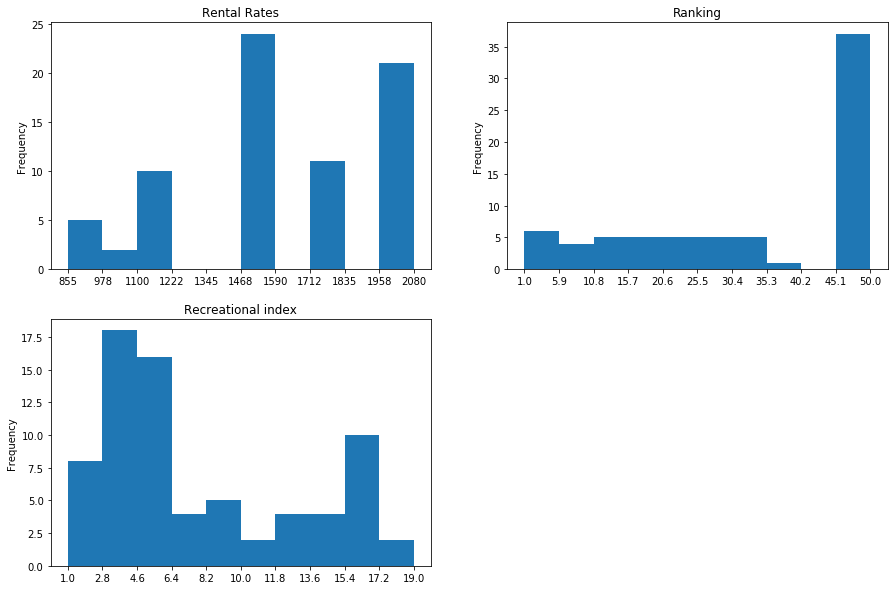

In [615]:
# Plot histogram for feature set using subplots

fig = plt.figure(figsize=(15,10))


ax0=fig.add_subplot(2,2,1)
count, bin_edges = np.histogram(University_data['Rental Rates'])
University_data['Rental Rates'].plot(kind='hist', xticks=bin_edges, ax=ax0)
ax0.set_title('Rental Rates')

ax1=fig.add_subplot(2,2,2)
count, bin_edges = np.histogram(University_data['Ranking'])
University_data['Ranking'].plot(kind='hist', xticks=bin_edges, ax=ax1)
ax1.set_title('Ranking')

ax2=fig.add_subplot(2,2,3)
count, bin_edges = np.histogram(University_data['Recreational Index'])
University_data['Recreational Index'].plot(kind='hist', xticks=bin_edges, ax=ax2)
ax2.set_title('Recreational index')


In [581]:
# Make a copy of the data
University_data_cat = University_data.copy(deep=True)

# Categorize the 'Rental Rate' feature
for ranking in University_data_cat['Rental Rates']:
    if ranking < 1000:
        University_data_cat['Rental Rates'].replace(to_replace=[ranking], value=['Cheap'], inplace=True)
    elif ranking >= 1000 and ranking <= 1200:
        University_data_cat['Rental Rates'].replace(to_replace=[ranking], value=['Affordable'], inplace=True)
    elif ranking > 1200 and ranking < 1800:
        University_data_cat['Rental Rates'].replace(to_replace=[ranking], value=['Expensive'], inplace=True)
    else:
        University_data_cat['Rental Rates'].replace(to_replace=[ranking], value=['Luxury'], inplace=True)

        
# Categorize the 'Ranking' feature        
for ranking in University_data_cat['Ranking']:
    if ranking >= 1 and ranking <= 10:
        University_data_cat['Ranking'].replace(to_replace=[ranking], value=['High Rank'], inplace=True)
    elif ranking > 10 and ranking <= 29:
        University_data_cat['Ranking'].replace(to_replace=[ranking], value=['Mid Rank'], inplace=True)
    elif ranking > 29 and ranking <= 36:
        University_data_cat['Ranking'].replace(to_replace=[ranking], value=['Low Rank'], inplace=True)
    else:
        University_data_cat['Ranking'].replace(to_replace=[ranking], value=['No Rank'], inplace=True)

        
# Categorize the 'Recreational Index' feature
for ranking in University_data_cat['Recreational Index']:
    if ranking >= 1 and ranking <= 4:
        University_data_cat['Recreational Index'].replace(to_replace=[ranking], value=['Sparse'], inplace=True)
    elif ranking > 4 and ranking < 12:
        University_data_cat['Recreational Index'].replace(to_replace=[ranking], value=['Fun'], inplace=True)
    else:
        University_data_cat['Recreational Index'].replace(to_replace=[ranking], value=['Exciting'], inplace=True)

**Implement one-hot encoding on future set**

In [582]:
# one hot encoding
University_data_onehot=[]
University_data_onehot = pd.get_dummies(University_data_cat[['Recreational Index', 'Ranking', 'Rental Rates']])

University_data_onehot

,Recreational Index_Exciting,Recreational Index_Fun,Recreational Index_Sparse,Ranking_High Rank,Ranking_Low Rank,Ranking_Mid Rank,Ranking_No Rank,Rental Rates_Affordable,Rental Rates_Cheap,Rental Rates_Expensive,Rental Rates_Luxury
0,1,0,0,1,0,0,0,0,0,0,1
1,0,0,1,1,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,0,0,0,1
4,0,0,1,1,0,0,0,0,0,1,0
5,1,0,0,1,0,0,0,1,0,0,0
6,0,0,1,1,0,0,0,1,0,0,0
7,1,0,0,1,0,0,0,0,0,0,1
8,0,1,0,1,0,0,0,0,0,0,1
9,1,0,0,1,0,0,0,0,0,0,1


**Implement k-means clustering machine learning algorithm**

In [583]:
# Normalize Feature set
x = University_data_onehot[['Recreational Index_Exciting', 'Recreational Index_Sparse',
       'Recreational Index_Fun', 'Ranking_High Rank', 'Ranking_Low Rank',
       'Ranking_Mid Rank', 'Ranking_No Rank', 'Rental Rates_Cheap',
       'Rental Rates_Expensive', 'Rental Rates_Affordable',
       'Rental Rates_Luxury']]
x = StandardScaler().fit(x).transform(x)


# Implement k-means clustering algorithm
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(init='k-means++', n_init=12, n_clusters=kclusters, random_state=0).fit(x)

kmeans.labels_ # cluster labels                                                  

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 7, 6, 6, 6, 5, 6, 6, 6, 0, 7, 0,
       7, 6, 7, 0, 7, 0, 6, 4, 4, 4, 4, 4, 4, 5, 3, 9, 1, 5, 2, 5, 5, 1,
       3, 3, 3, 3, 5, 2, 2, 9, 5, 0, 0, 0, 1, 3, 9, 3, 2, 2, 1, 3, 2, 1,
       9, 2, 1, 9, 1, 3, 5])

**Ascribe a description to each clusters. These descriptions serve as the markers that would guide prospective students to the cluster in which to further explore**

In [555]:
# Evaluate clusters
University_data_onehot['Cluster Label'] = kmeans.labels_
University_data_onehot.groupby('Cluster Label', as_index=False).sum()

,Cluster Label,Recreational Index_Exciting,Recreational Index_Fun,Recreational Index_Sparse,Ranking_High Rank,Ranking_Low Rank,Ranking_Mid Rank,Ranking_No Rank,Rental Rates_Affordable,Rental Rates_Cheap,Rental Rates_Expensive,Rental Rates_Luxury
0,0,0,3,4,0,0,4,3,0,7,0,0
1,1,0,7,0,0,0,0,7,0,0,4,3
2,2,7,0,0,0,0,0,7,0,0,3,4
3,3,0,0,9,0,0,0,9,0,0,9,0
4,4,2,2,2,0,6,0,0,0,0,1,5
5,5,1,5,2,0,1,1,6,8,0,0,0
6,6,0,8,1,0,0,9,0,0,0,3,6
7,7,5,0,0,0,0,5,0,0,0,2,3
8,8,5,2,3,10,0,0,0,2,0,2,6
9,9,0,0,5,0,0,0,5,0,0,0,5


**Observing the above, it is evident that the dataset has been sufficiently discriminated and clustered. The description of the various clusters will now be summarized.**

In [631]:
# Summary of cluster analysis

cluster_description = pd.DataFrame({'Cluster Label':range(kclusters), 'Description':['Cheap rent. Mid and null ranked. Sparse and fun recreation', 
                                                   'Expensive and luxury rent. Null ranked. Fun recreation', 
                                                   'Expensive and luxury rent. Null ranked. Exciting recreation', 
                                                   'Expensive rent. Null ranked. Sparse recreation', 
                                                   'Expensive and luxury rent. Low ranked', 
                                                   'Affordable rent', 
                                                   'Expensive and luxury rent. Mid ranked. Sparse and fun recreation', 
                                                   'Expensive and luxury rent. Mid ranked. Exciting recreation', 
                                                   'Expensive and luxury rent. High ranked', 
                                                   'Luxury rent. Null ranked. Sparse recreation']})

cluster_description.set_index('Cluster Label')

,Description
Cluster Label,
0,Cheap rent. Mid and null ranked. Sparse and fun recreation
1,Expensive and luxury rent. Null ranked. Fun recreation
2,Expensive and luxury rent. Null ranked. Exciting recreation
3,Expensive rent. Null ranked. Sparse recreation
4,Expensive and luxury rent. Low ranked
5,Affordable rent
6,Expensive and luxury rent. Mid ranked. Sparse and fun recreation
7,Expensive and luxury rent. Mid ranked. Exciting recreation
8,Expensive and luxury rent. High ranked


**A peek into the Universities in Cluster 1 below validates the description provided: they all have null ranks, are situated in provinces having expensive and luxury rents, and offer 'fun' recreation**

In [658]:
# Make a copy of the data
University_data_display = University_data_cat.copy(deep=True)

# Clean up and modify final Datafarme for display
University_data_display.drop(['Latitude', 'Longitude'], axis=1, inplace=True) # drop irrelevant columns
University_data_display.insert(0, 'Cluster Label', kmeans.labels_) # insert the Cluster Labels

# Input request for desired cluster label
label = input('Please Input the Cluster Label you wish to explore (0-9) = ') 
print('\nThe Canadian University Data consistent with the cluster selected is given below:')
print('\nCluster Description: {}'.format(cluster_description.loc[int(label), 'Description']))

# Filter dataset to display data for inputted cluster label 
Cluster = University_data_display[University_data_display['Cluster Label']==int(label)] 
Cluster

Please Input the Cluster Label you wish to explore (0-9) = 1

The Canadian University Data consistent with the cluster selected is given below:

Cluster Description: Expensive and luxury rent. Null ranked. Fun recreation


,Cluster Label,Province,University,City,Rental Rates,Ranking,Recreational Index
38,1,Quebec,Bishop's University,Sherbrooke,Expensive,No Rank,Fun
43,1,Quebec,Université du Québec en Abitibi-Témiscamingue,"Rouyn-Noranda, Mont-Laurier",Expensive,No Rank,Fun
56,1,Nova Scotia,Acadia University,Wolfville,Expensive,No Rank,Fun
62,1,Nova Scotia,Saint Francis Xavier University,Antigonish,Expensive,No Rank,Fun
65,1,British Columbia,University of Northern British Columbia,Prince George,Luxury,No Rank,Fun
68,1,British Columbia,University of the Fraser Valley,"Abbotsford, Chilliwack, Mission",Luxury,No Rank,Fun
70,1,British Columbia,Thompson Rivers University,Kamloops,Luxury,No Rank,Fun


**Full dataset with Cluster Labels and *categorized* feature set is given below:**

In [661]:
University_data_display.sort_values('Cluster Label', ascending=True).reset_index(drop=True)

,Cluster Label,Province,University,City,Rental Rates,Ranking,Recreational Index
0,0,Saskatchewan,University of Saskatchewan,Saskatoon,Cheap,Mid Rank,Sparse
1,0,Saskatchewan,University of Regina,"Regina, Saskatoon, Swift Current",Cheap,Mid Rank,Sparse
2,0,New Brunswick,University of New Brunswick,"Fredericton, Saint John",Cheap,Mid Rank,Fun
3,0,Newfoundland and Labrador,Memorial University of Newfoundland,"St. John's, Corner Brook, Harlow (United Kingdom)",Cheap,Mid Rank,Fun
4,0,New Brunswick,Université de Moncton,"Moncton, Shippagan, Edmundston",Cheap,No Rank,Sparse
5,0,New Brunswick,St. Thomas University,Fredericton,Cheap,No Rank,Sparse
6,0,New Brunswick,Mount Allison University,Sackville,Cheap,No Rank,Fun
7,1,British Columbia,Thompson Rivers University,Kamloops,Luxury,No Rank,Fun
8,1,British Columbia,University of the Fraser Valley,"Abbotsford, Chilliwack, Mission",Luxury,No Rank,Fun
9,1,Quebec,Université du Québec en Abitibi-Témiscamingue,"Rouyn-Noranda, Mont-Laurier",Expensive,No Rank,Fun


**Full dataset with Cluster Labels and *native* feature set is given below:**

In [664]:
University_data_display_2 = University_data.drop(['Latitude', 'Longitude'], axis=1) # drop irrelevant columns
University_data_display_2.insert(0, 'Cluster Label', kmeans.labels_) # insert the Cluster Labels
University_data_display_2.sort_values('Cluster Label', ascending=True).reset_index(drop=True)

,Cluster Label,Province,University,City,Rental Rates,Ranking,Recreational Index
0,0,Saskatchewan,University of Saskatchewan,Saskatoon,995.0,20.0,1.0
1,0,Saskatchewan,University of Regina,"Regina, Saskatoon, Swift Current",995.0,28.0,3.0
2,0,New Brunswick,University of New Brunswick,"Fredericton, Saint John",855.0,26.0,5.0
3,0,Newfoundland and Labrador,Memorial University of Newfoundland,"St. John's, Corner Brook, Harlow (United Kingdom)",855.0,22.0,6.0
4,0,New Brunswick,Université de Moncton,"Moncton, Shippagan, Edmundston",855.0,50.0,4.0
5,0,New Brunswick,St. Thomas University,Fredericton,855.0,50.0,3.0
6,0,New Brunswick,Mount Allison University,Sackville,855.0,50.0,6.0
7,1,British Columbia,Thompson Rivers University,Kamloops,1800.0,50.0,9.0
8,1,British Columbia,University of the Fraser Valley,"Abbotsford, Chilliwack, Mission",1800.0,50.0,6.0
9,1,Quebec,Université du Québec en Abitibi-Témiscamingue,"Rouyn-Noranda, Mont-Laurier",1495.0,50.0,6.0


### Charts

Having derived and described our University clusters primarily employing the k-means clustering algorithm, the respective clusters are subjected to analysis based on University distribution among the feature set parameters. Analysis results are presented in charts.

A function to plot the **'Feature Set Distribution Charts'** is first defined.

In [769]:
# Define function to plot charts
def chart(column_label):
    chart = pd.get_dummies(University_data_display[[column_label]])
    chart.insert(0, 'Cluster Label', kmeans.labels_)
    chart = chart.groupby('Cluster Label').sum()
    ax = chart.plot.bar(figsize=(15,5))
    ax.set_title('University Distribution in Clusters Based on {}'.format(column_label), fontsize=15)
    ax.set_xlabel('Cluster Label', fontsize=12)
    ax.set_ylabel('No of Universities', fontsize=12)

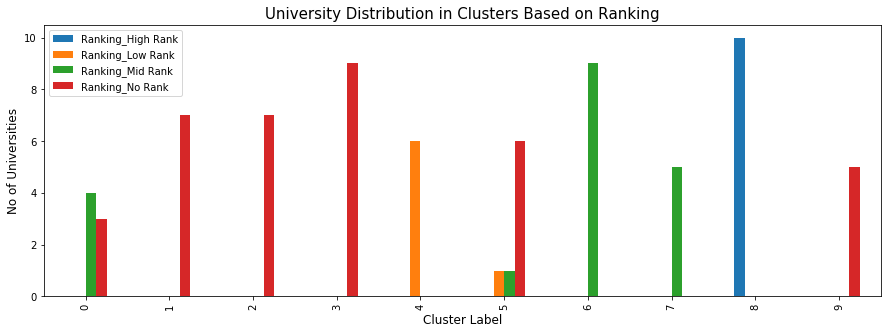

In [770]:
chart('Ranking')

**University distribution in clusters with respect to their ranking is displayed above.** 
**Gleaning insight from the chart, students looking to study in high ranking Universities would directly explore the options in Cluster 8**

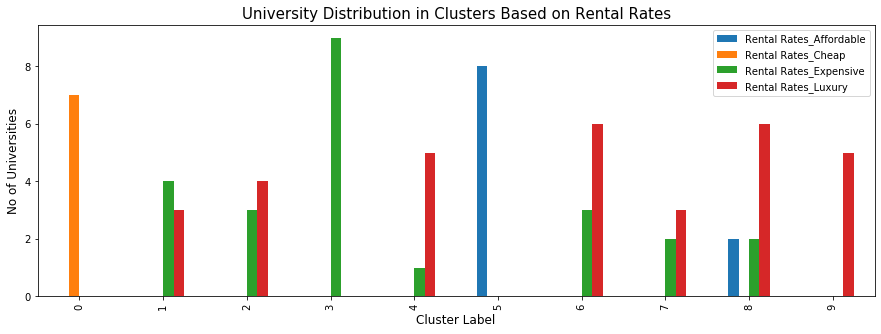

In [771]:
chart('Rental Rates')

**Prospective students whose primary consideration is cheap rent would readily explore Universities in Cluster 0**

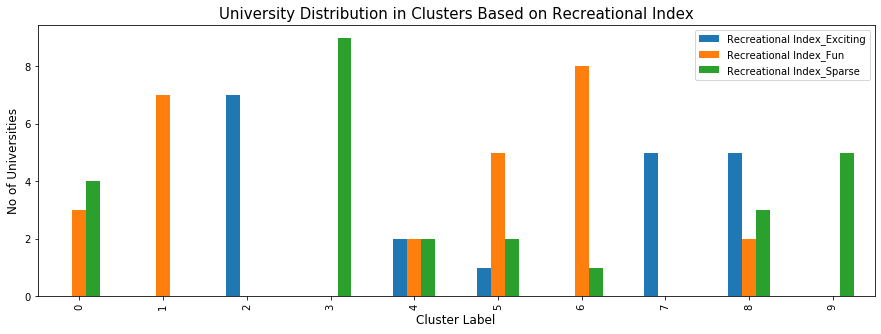

In [772]:
chart('Recreational Index')

**For those prospective students who consider recreation as an integral component of the educational experience, Clusters 2 and 7 offer exclusively 'Exciting' Universities. Clusters 4, 5 and 8 also present further options.**

**No single chart would be effective in isolation as prospective students would usually have at least two features they consider imperative to their University education experience. Consequenty, the charts should be used in combination for the best results. Cheers!!!**